In [1]:
import pandas as pd

### 0. Загружаем данные, оптимизируем типы данных для уменьшения объема используемой памяти, проверяем, что все корректно:

In [2]:
train = pd.read_csv('train.csv', sep=',', index_col=0,
                       dtype = {'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 
                                'content_type_id': 'int8', 'task_container_id': 'int16', 'user_answer': 'int8', 
                                'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                                'prior_question_had_explanation': 'boolean'
                               }
                      )

In [3]:
train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 3.1 GB


In [6]:
"""
Для удобства анализа приведем последний столбец к числовому типу
Сначала переведем пустые значения в False (в целях анализа эти значения равнозначны)
Затем конвертируем в числовой формат
"""
for i in range(train.shape[0]):
    if pd.isna(train['prior_question_had_explanation'][i]) == True:
        train['prior_question_had_explanation'][i] = False
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('int8')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  int8   
dtypes: float32(1), int16(2), int32(1), int64(1), int8(4)
memory usage: 3.0 GB


## 1. Исследуем данные Train
Перевод имен колонок (для удобства):
- **row_id: (int64)** ID строки
- **timestamp: (int64)** время в милисекундах между началом сессии и завершением задания юзером
- **user_id: (int32)** ID юзера
- **content_id: (int16)** ID вопроса/лекции
- **content_type_id: (int8)** 0 - вопрос(ы), 1 - лекция
- **task_container_id: (int16)** ID блока вопросов или лекции (может включать в себя несколько content_id)
- **user_answer: (int8)** ответ юзера на вопрос. -1 - пустое значение для лекций
- **answered_correctly: (int8)** 1 -ответил верно, 0 -неверно, -1 -пустое значение для лекций
- **prior_question_elapsed_time: (float32)** среднее время в милисекундах, затраченное юзером на ответы на предыдущий блок вопросов (лекции в промежутке игнорируются). Для первого - значение 0.
- **prior_question_had_explanation: (bool)** видел ли юзер правильный ответ и объяснение на предыдущий блок вопросов (лекции в промежутке игнорируются). Для первого - значение 0. Обычно первые вопросы, которые видит юзер - вступительный тест, на который нет фидбека.


In [9]:
"""
Исследуем кол-во уникальных значений для разных колонок
"""
unique_list = []
for col in train.columns:
    item = (col, train[col].nunique(), train[col].dtype)
    unique_list.append(item)
unique_counts = pd.DataFrame(unique_list,
                             columns=['Column_Name', 'Num_Unique', 'Type']
                            ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts)

,Column_Name,Num_Unique,Type
0,content_type_id,2,int8
1,prior_question_had_explanation,2,int8
2,answered_correctly,3,int8
3,user_answer,5,int8
4,prior_question_elapsed_time,3258,float32
5,task_container_id,10000,int16
6,content_id,13782,int16
7,user_id,393656,int32
8,timestamp,72821015,int64


In [79]:
"""
Данные с небольшим кол-вом уникальных значений можно исследовать дополнительно для корректной категоризации
Начнем с типов активности: 0 - вопрос(ы), 1 - лекция
"""
train['content_type_id'].value_counts(normalize=True) 
train['content_type_id'].value_counts()[0] 
train['content_type_id'].value_counts()[1] 

# 98% активновти студентов приходится на ответы на вопросы:
# общее кол-во ответов на вопросы - 99271300
# общее кол-во просмотров лекций - 1959032

1.0106370331624595

In [10]:
"""
Исследуем соотношение правильных и неправильных ответов (исключаем из рассмотрения лекции)
"""
train[train['answered_correctly'] != -1]['answered_correctly'].value_counts(normalize=True) 
train[train['answered_correctly'] != -1]['answered_correctly'].value_counts()[1] 
train[train['answered_correctly'] != -1]['answered_correctly'].value_counts()[0]
train[train['answered_correctly'] != -1]['answered_correctly'].mean()

# 66% составляют правильные ответы, 34% - неправильные
# всего 65244627 правильных ответов и 34026673 неправильных ответов
# 0.657 - средний балл студента

In [536]:
"""
Посчитаем среднее время на решение вопроса
"""
train['prior_question_elapsed_time'].mean()

13005.0810546875

In [541]:
"""
Приведем средние данные по общей базе данных:
"""
train[train['content_type_id'] == 0].shape[0] / train['user_id'].nunique()
train[train['answered_correctly'] != -1]['answered_correctly'].sum() / train['user_id'].nunique()
train[train['content_type_id'] == 1].shape[0] / train['user_id'].nunique()
train['prior_question_had_explanation'].sum() / train['user_id'].nunique()
train['prior_question_elapsed_time'].mean()

# Cреднее число отвеченных вопросов: 252.17
# Среднее кол-во правильных ответов: 165.74
# Среднее число просмотренных лекций: 4.97
# Среднее число виденных объяснений: 227.82
# Среднее время, затрачиваемое на вопрос: 13005

In [12]:
"""
Посмотрим, есть ли разница в % правильных ответов в зависиомсти от:
- времени с начала сессии
- среднего времеми ответа студента на вопросы
- видел ли студент правильный ответ на предыдущее задание
"""
pd.DataFrame({'timestamp': train[train['answered_correctly'] != -1]['timestamp'].groupby(train['answered_correctly']).mean(),
              'prior_questions_time': train[train['answered_correctly'] != -1]['prior_question_elapsed_time'].groupby(train['answered_correctly']).mean(),
              'had_explanation': train[train['answered_correctly'] != -1]['prior_question_had_explanation'].groupby(train['answered_correctly']).sum()
             }
            )

# Можно сделать следующие выводы:
# - чем ближе к началу сессии вопрос, тем менее успешно его проходят студенты 
# (т.е. успешность коррелирует со временем, проведенным на платформе)
# - студенты, тратящие меньше времени на решение, чаще отвечают правильно
# - если студент видел объяснение предыдущий задачи, вероятность правильного ответа удваивается

,timestamp,prior_questions_time,had_explanation
answered_correctly,,,
0,7.235711e+09,25641.992188,29310272.0
1,7.945270e+09,25309.976562,60375288.0


### Основные выводы по разделу 1:

- Всего в данных присутствует информация об активности 393656 студентов.
- На платформе 13523 вопросов (объединенных в 10000 блоков) и 418 лекций по 7 темам.
- В среднем на ответ на вопрос у студентов уходит 
- 98% активновти студентов приходится на ответы на вопросы, только 2% татится на просмотр лекций.
- 66% составляют правильные ответы, 34% - неправильные.
- 0.657 - средний балл студента
- Cреднее число отвеченных вопросов: 252.17
- Среднее кол-во правильных ответов: 165.74
- Среднее число просмотренных лекций: 4.97
- Среднее число виденных объяснений: 227.82
- Среднее время, затрачиваемое на вопрос: 13005
- Cреднее время на решение вопроса 13005 милисекунд (= 13 секунд)
- Чем ближе к началу сессии вопрос, тем менее успешно его проходят студенты (т.е. успешность коррелирует со временем, проведенным на платформе)
- Студенты в среднем тратят меньше времени на правильный ответ, чем на неправильный (возможно, меньше сомневаются)
- Если студент видел объяснение предыдущий задачи, он в 2 раза чаще отвечает правильно, чем неправильно

---

## 2. Для дальнейшего анализа создадим новый DataFrame с данными, агрегированными по студентам
students

Добавим данные:
- **user_id**: ID студента
- **time**: время, проведенное на платформе
- **ques_quant**: количество отвеченных вопросов
- **av_grade**: средний балл студента
- **lec_watched**: кол-во просмотренных лекций
- **expl_watched**: кол-во виденных объяснений на предыдущие вопросы

In [478]:
"""
Cоставим новый дф по уникальным id студентов
Cначала сформируем необходимые списки для df
"""
sudents_list = list(train['user_id'].unique())
users_q = len(sudents_list)

# Всего 393656 уникальных студентов

In [ ]:
"""
Поскольку число уникальных студентов слишком велико для быстрой обработки, 
возьмем из нее 500 уникальных и проанализируем их активность.
"""
sudents_list = sudents_list[:500]

In [479]:
"""
Посчитаем время на платформе для каждого студента
"""
time = []
for student in sudents_list:
    t = train[train['user_id'] == student]['timestamp'].max()
    time.append(t)

In [480]:
"""
Количество отвеченных вопросов
"""
ques_quant = []
for student in sudents_list:
    q = train[(train['user_id'] == student) & (train['content_type_id'] == 0)]['content_type_id'].count()
    ques_quant.append(q)

In [481]:
"""
Cредний балл студента
"""
av_grade = []
for student in sudents_list:
    g = train[(train['user_id'] == student) & (train['answered_correctly'] != -1)]['answered_correctly'].mean()
    av_grade.append(g)

In [482]:
"""
Кол-во просмотренных лекций
"""
lec_watched = []
for student in sudents_list:
    l = train[train['user_id'] == student]['content_type_id'].sum()
    lec_watched.append(l)

In [483]:
"""
Кол-во виденных объяснений на предыдущие вопросы
"""
expl_watched = []
for student in sudents_list:
    e = train[train['user_id'] == student]['prior_question_had_explanation'].sum()
    expl_watched.append(e)

In [535]:
"""
Время, в среднем потраченное студентом на каждый вопрос
"""
ques_time = []
for student in sudents_list:
    qt = train[(train['user_id'] == student)]['prior_question_elapsed_time'].mean()
    ques_time.append(qt)

In [545]:
"""
Запишем данные по 500 отобранным студентам в единую таблицу
"""
students = pd.DataFrame({'user_id': sudents_list,
                        'time': time,
                        'ques_quant': ques_quant,
                        'av_grade': av_grade,
                        'lec_watched': lec_watched,
                        'expl_watched': expl_watched,
                         'ques_time': ques_time
                       }
                      )
students = students.astype({'user_id': 'int32',
                            'time': 'int64',
                            'ques_quant': 'int16', 
                            'av_grade': 'float32',
                            'lec_watched': 'int16',
                            'expl_watched': 'int16',
                            'ques_time': 'float32'
                           })

In [546]:
students.head()

,user_id,time,ques_quant,av_grade,lec_watched,expl_watched,ques_time
0,115,668090043,46,0.695652,0,6,19933.310547
1,124,571323,30,0.233333,0,0,18793.000000
2,2746,835457,19,0.578947,1,11,18055.554688
3,5382,2101551456,125,0.672000,3,113,36048.386719
4,8623,862338736,109,0.642202,3,96,26107.408203


In [547]:
"""
Посмотрим, насколько наша выборка похожа на общие данные:
"""
students.describe()

# Мы видим, что наша выборка средними значениями отличается от общего датасета:
# средняя успеваемость у нашей группы ниже, чем у полного набора данных, 
# при этом среднее число просмотренных лекций и объяснений выше
# (за счет относительно небольшого кол-ва очень активно учащихся студентов
# это видно из смещения кол-ва отвеченных вопросов, просмотренных лекций и объяснений в верхний квартиль
# и высокой дисперсии)
# Однако все значения укладываются в среднеквадратическое отклонение, 
# поэтому можем считать их несущественными для результатов анализа

,user_id,time,ques_quant,av_grade,lec_watched,expl_watched,ques_time
count,5.000000e+02,5.000000e+02,500.000000,500.000000,500.000000,500.000000,499.000000
mean,1.468722e+06,5.361427e+09,276.574000,0.554668,5.240000,253.600000,23859.998047
std,8.476328e+05,1.025473e+10,757.372753,0.165881,17.461851,751.298414,7225.852539
min,1.150000e+02,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1344.862061
25%,7.444190e+05,1.395153e+06,30.000000,0.441731,0.000000,9.000000,19370.302734
50%,1.514318e+06,4.714174e+08,45.000000,0.580850,0.000000,22.500000,22924.494141
75%,2.201334e+06,5.065056e+09,171.750000,0.674960,2.000000,142.000000,26889.037109
max,2.909984e+06,6.370152e+10,7476.000000,1.000000,181.000000,7465.000000,60351.351562


<AxesSubplot:>

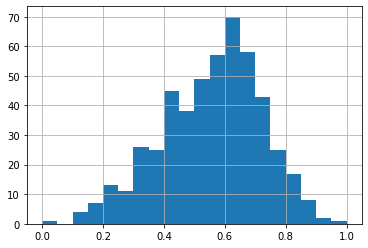

In [544]:
"""
Гистограма распределения средних оценок среди студентов
"""
students['av_grade'].hist(bins=20)

In [523]:
students['av_grade'].median()

0.5808496475219727

### Проанализируем зависимость успешности студента от:
- индивидуального времени, проведенного на платформе
- кол-ва сделанных заданий
- кол-ва виденных объяснений
- кол-ва времени, затраченного на каждый вопрос
- кол-ва просмотренных лекций

<AxesSubplot:xlabel='av_grade', ylabel='time'>

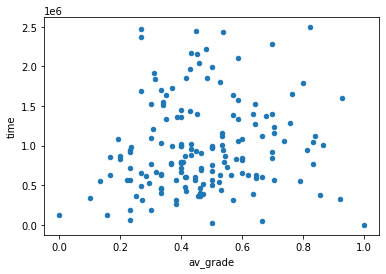

In [506]:
"""
Построим диаграмму рассеяния, показывающую зависимость правильных ответов от веремени, проведенного на платформе
Чтобы убрать выбросы, ограничим время 3000000.
"""
students[students['time'] < 3000000].plot.scatter(x='av_grade', y='time')

# Из графика неочевидно, что с ростом времени, затраченного на платформе, растет процент правильных ответов у студентов
# Можем сделать 2 предположения:
# - либо время, проведенное на платформе не имеет значимого влияния на успеваемость
# - либо для эффекта нужно затрачивать время сильно больше, чем это делает большинство студентов
# (возможно студенты слишком рано бросают занятия)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

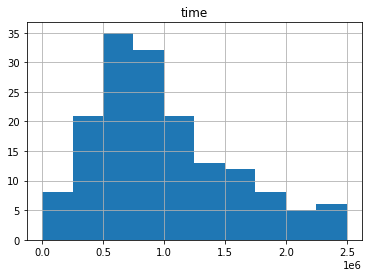

In [527]:
"""
Посмотрим на гистограмме, в какой момент большинство студентов прекращает занятия
"""
students[students['time'] < 3000000].hist(column=['time'])

# Мы видим, что после 1000000 милисекунд (=17 минут) 1/5 часть студентов не продолжает обучения, 
# после 2500000 милисекунд (=42 минуты) учебу бросает уже треть
# Получается, то, что мы изначально сочли выбросами - это наша основная рабочая выборка, которую надо исследовать,
# чтобы понять влияние факторов на успеваемость. 

In [528]:
# строка для проверки данных отсечения
students[students['time'] < 2500000].shape

(161, 8)

<AxesSubplot:xlabel='av_grade', ylabel='time'>

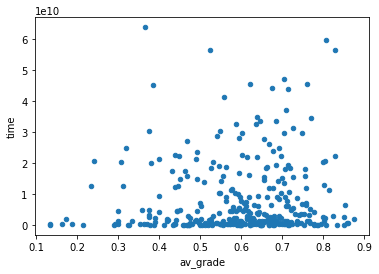

In [529]:
"""
Построим диаграмму рассеяния для студентов, не бросивших учебу в течение 1го часа.
"""
students[students['time'] > 3000000].plot.scatter(x='av_grade', y='time')

# Здесь уже становится видна тенденция роста успеваемости с течением веремени

In [598]:
"""
Для наглядности проведем разбиение студентов по временным группам:
 - Добавим столбец с временной группировкой
 - Построим диаграмму размаха
"""

def time_convert(e):
    if e < students['time'].quantile(0.1): return 0
    elif e < students['time'].quantile(0.2): return 1
    elif e < students['time'].quantile(0.3): return 2
    elif e < students['time'].quantile(0.4): return 3
    elif e < students['time'].quantile(0.5): return 4
    elif e < students['time'].quantile(0.6): return 5
    elif e < students['time'].quantile(0.7): return 6
    elif e < students['time'].quantile(0.8): return 7
    elif e < students['time'].quantile(0.9): return 8
    else: return 9
    
students['time_group'] = students['time'].apply(time_convert)

<AxesSubplot:title={'center':'av_grade'}, xlabel='[time_group]'>

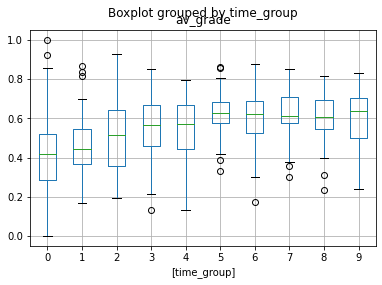

In [599]:
students.boxplot(column=['av_grade'], by=['time_group'])

# Первый эффект от занятий становится виден, если студент не бросает заниматься
# При этом, если студент потратил на занятия не менее 55 часов, его оценка становится устойчиво выше средней
# и продолжает расти со временем.
# Однако, если курс не пройден за ~ полгода, оценка становится нестабильной
# Т.е. стоит не только стимулировать студентов не бросать занятия после первого подхода,
# но и закончить курс за первые полгода обучения.

In [615]:
students['time'].quantile(0.7)/1000/60/60/8

118.11600010069442

<AxesSubplot:xlabel='av_grade', ylabel='ques_quant'>

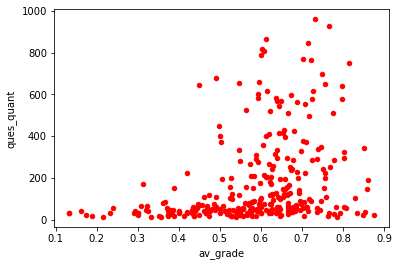

In [556]:
"""
Построим диаграмму рассеяния, показывающую зависимость правильных ответов от кол-ва сделанных заданий
Ограничим выборку студентами, не бросившими обучение сразу.
"""
students[(students['ques_quant'] < 1000) & (students['time'] > 3000000)].plot.scatter(x='av_grade', y='ques_quant', c='red')

# чтобы убрать выбросы, ограничим данные сверху 1000
# На графике довольно очевидна связь успеваемости с кол-вом отвеченных вопросов
# Стоит провести группировку вопросов по кол-ву для дальнейшего анализа

In [593]:
"""
Построим новый столбец с группировкой по кол-ву отвеченных вопросов
Далее строим диаграмму размаха
"""
def ques_convert(e):
    if e < students['ques_quant'].quantile(0.1): return 0
    elif e < students['ques_quant'].quantile(0.2): return 1
    elif e < students['ques_quant'].quantile(0.3): return 2
    elif e < students['ques_quant'].quantile(0.4): return 3
    elif e < students['ques_quant'].quantile(0.5): return 4
    elif e < students['ques_quant'].quantile(0.6): return 5
    elif e < students['ques_quant'].quantile(0.7): return 6
    elif e < students['ques_quant'].quantile(0.8): return 7
    elif e < students['ques_quant'].quantile(0.9): return 8
    else: return 9
    
students['q_group'] = students['ques_quant'].apply(ques_convert)

<AxesSubplot:title={'center':'av_grade'}, xlabel='[q_group]'>

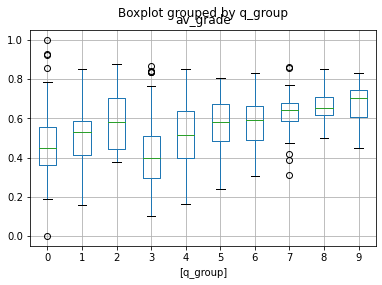

In [594]:
students.boxplot(column=['av_grade'], by=['q_group'])

# Мы видим странную просадку в 4м квартиле

In [600]:
students['ques_quant'].quantile(0.4)

31.600000000000023

array([[<AxesSubplot:title={'center':'ques_quant'}>]], dtype=object)

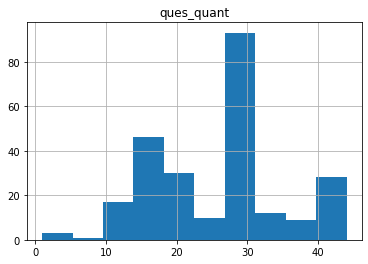

In [601]:
# Можем предположить, что первые вопросы являются сильным демотиватором для учащегося.
# Но если студент отвечает больше, чем на 34 вопроса, он постепенно начинает улучшать свои показатели
# И дальше результаты только улучшаются
# На гистограме видно, что 32 вопроса - порог отсечения для многих студентов из нашей выборки

students[(students['ques_quant'] < students['ques_quant'].quantile(0.5))].hist(column=['ques_quant'])

<AxesSubplot:xlabel='av_grade', ylabel='expl_watched'>

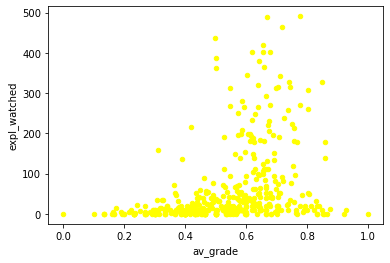

In [560]:
"""
Построим диаграмму рассеяния, показывающую зависимость правильных ответов от кол-ва виденных объяснений
"""
students[(students['expl_watched'] < 500)].plot.scatter(x='av_grade', y='expl_watched', c='yellow')

In [591]:
"""
Построим новый столбец с группировкой по кол-ву правильных ответов
Далее строим диаграмму размаха
"""
def expl_convert(e):
    if e < students['expl_watched'].quantile(0.1): return 0
    elif e < students['expl_watched'].quantile(0.2): return 1
    elif e < students['expl_watched'].quantile(0.3): return 2
    elif e < students['expl_watched'].quantile(0.4): return 3
    elif e < students['expl_watched'].quantile(0.5): return 4
    elif e < students['expl_watched'].quantile(0.6): return 5
    elif e < students['expl_watched'].quantile(0.7): return 6
    elif e < students['expl_watched'].quantile(0.8): return 7
    elif e < students['expl_watched'].quantile(0.9): return 8
    else: return 9
    
students['e_group'] = students['expl_watched'].apply(expl_convert)

In [581]:
students['expl_watched'].quantile(0.5)

22.5

array([[<AxesSubplot:title={'center':'expl_watched'}>]], dtype=object)

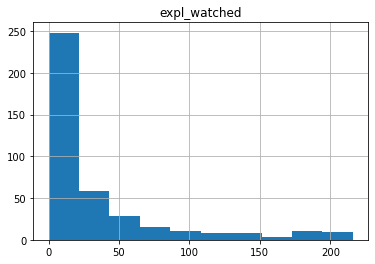

In [587]:
# здесь мы видим, что 34 вопроса - порог отсечения для многих студентов
students[(students['expl_watched'] < students['expl_watched'].quantile(0.8))].hist(column=['expl_watched'])

<AxesSubplot:title={'center':'av_grade'}, xlabel='[e_group]'>

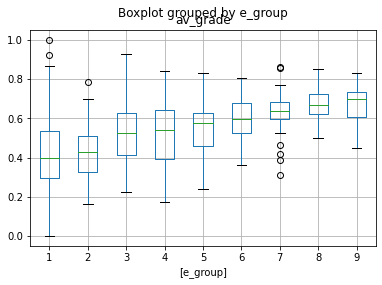

In [592]:
students.boxplot(column=['av_grade'], by=['e_group'])

# Видно четкий тренд на повышение оценки с ростом кол-ва просмотренных объяснений

<AxesSubplot:xlabel='av_grade', ylabel='lec_watched'>

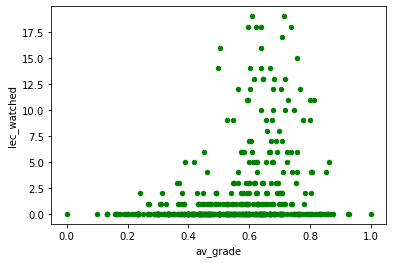

In [297]:
"""
Построим диаграмму рассеяния, показывающую зависимость правильных ответов от кол-ва просмотренных лекций
"""
students[students['lec_watched'] < 21].plot.scatter(x='av_grade', y='lec_watched', c='green')

# Мы видим, что экстремальные выбросы можно убрать, ограничив число 21 лекцией

<AxesSubplot:title={'center':'av_grade'}, xlabel='[lec_watched]'>

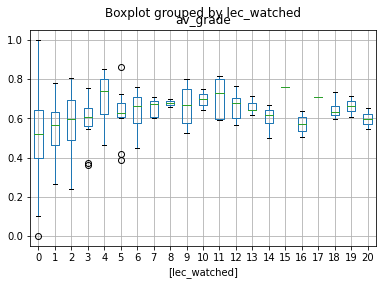

In [360]:
"""
Построим диаграмму размаха, показывающую зависимость правильных ответов от кол-ва просмотренных лекций
"""
students[students['lec_watched'] < 21].boxplot(column=['av_grade'], by=['lec_watched'])

# Мы видим, что даже просмотр 1 леции повышает средний балл и значительно повышает минимальную оценку студента.
# Максимальный эффект достигается при просмотре 4-11 лекций, после чего эффективность просмотров снижается

### Основные выводы по разделу 2

Мы сделали выборку из общего объема данных по 500 студентам. 
С учетом проведенного анализа мы можем сделать следующие выводы:

1. Треть студентов бросает учебу, проведя на платформе менее 42 минут. За это время, вероятно, они не успевают почувствовать эффект, либо им просто что-то не нравится (недостаточно мотивации / слишком сложные вопросы / неудобный интерфейс и т.д.).

2. Если студент потратил на занятия не менее 55 часов, его оценка становится устойчиво выше средней и продолжает расти со временем. 

3. Если курс не пройден за ~ полгода, оценка становится нестабильной. Т.е. стоит не только стимулировать студентов не бросать занятия после первого подхода, но и закончить курс за первые полгода обучения.

4. Анализ данных по кол-ву отвеченных вопросов подсказывает, что первые вопросы сильно демотивируют учащихся. Большая часть не преодолевает порог в 32 вопроса. Следует стимуляровать студентов к ответу хотя бы на первые 60 вопросов, чтобы добиться устойчивого улучшения результатов и мотивации к дальнейшему обучению.

5. С ростом кол-ва просмотренных объяснений устойчиво растет успеваемость студентов.

6. Если студент посмотрит более 4х лекций, его успеваемость значительно возрастет. При этом просмотр более 11 лекций по какой-то причине не улучшает ситуацию.

---

## 3. Добавим к исследованию данные из дополнительных файлов

### Исследуем данные "Вопросы"
questions.csv
- **question_id:** внешний ключ вопроса - соответствует content_id
- **bundle_id:** код, по которому вопросы отдаются совместно
- **correct_answer:** правильный ответ. Можно использовать для проверки правильности user_answer
- **part:** номер раздела в тесте TOEIC
- **tags:** кодировка типа вопроса, можно использовать для кластеризации вопросов

In [616]:
questions = pd.read_csv('questions.csv', sep=',',
                        dtype = {'question_id': 'int16', 'bundle_id': 'int16', 'correct_answer': 'int8',
                                 'part': 'int8', 'tags': 'object'
                               })
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
dtypes: int16(2), int8(2), object(1)
memory usage: 185.0+ KB


In [617]:
"""
Исследуем кол-во уникальных значений для разных колонок
"""
unique_list_q = []
for col in questions.columns:
    item = (col, questions[col].nunique(), questions[col].dtype)
    unique_list_q.append(item)
unique_counts_q = pd.DataFrame(unique_list_q,
                               columns=['Column_Name', 'Num_Unique', 'Type']
                              ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts_q)

,Column_Name,Num_Unique,Type
0,correct_answer,4,int8
1,part,7,int8
2,tags,1519,object
3,bundle_id,9765,int16
4,question_id,13523,int16


In [618]:
questions['question_id'].groupby(questions['bundle_id']).count().max()
questions['part'].value_counts(normalize=True)
questions['tags'].describe()

# Часть вопросов объединены по bundle_id в блоки до 5 вопросов, хотя большинство представлены по одиночке
# Задачи разделены по темам на 7 разделов, больше всего посвящено 5му разделу, 2, 3 и 4

count     13522
unique     1519
top           8
freq        738
Name: tags, dtype: object

In [639]:
q_tags = set()
for tag in questions['tags']:
    try:
        for t in tag.split():
                q_tags.add(int(t))
    except:
        q_tags.add(int(t))
len(q_tags)

# Можно провести доп исследование вопросов, используя кластеризацию по 188 доп.признакам 'tags'

188

In [145]:
"""
Для дальнейшего исследования вопросов создадим единую таблицу по их ID с данными Train
"""
tmp_df = train.loc[(train.content_type_id == 0), ['content_id', 'answered_correctly']]

In [619]:
"""
Столбец question_id:
"""
q_list = list(tmp_df['content_id'].unique())
len(q_list)

# Всего 13523 уникальных вопросов. Мы берем этот список из файла Train, чтобы иметь правильный порядок данных

13523

In [620]:
"""
Столбцы :
q_quant - общее количество ответов для каждого id
correct_quant - количество правильных ответов для каждого id
"""
q_quant = []
correct_quant = []
for q in q_list:
    tmp = tmp_df[tmp_df['content_id'] == q]['answered_correctly'].count()
    tmp1 = tmp_df[tmp_df['content_id'] == q]['answered_correctly'].sum()
    q_quant.append(tmp)
    correct_quant.append(tmp1)

In [627]:
"""
Запишем полученные данные в единую таблицу
"""
q_ex = pd.DataFrame({'question_id': q_list,
                        'q_quant': q_quant,
                        'correct_quant': correct_quant
                       }
                      )
q_ex = q_ex.astype({'question_id': 'int16', 'q_quant': 'int32', 'correct_quant': 'int32'})

In [ ]:
"""
Внесем полученные данные в таблицу questions (пересечением),
вначале удалив ненужные столбцы
"""
questions = questions.drop('correct_answer', axis=1)
questions = pd.merge(questions, q_ex, how='inner')

In [623]:
"""
Добавим дополнительный столбец:
Процент правильных ответов
"""
questions['correct_percent'] = questions['correct_quant'] / questions['q_quant']
questions.describe()

,question_id,bundle_id,part,q_quant,correct_quant,correct_percent
count,13523.00000,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,4.264956,7340.922872,4824.715448,0.709460
std,3903.89818,3903.857783,1.652553,11455.927774,6419.482619,0.164486
min,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,3380.50000,3379.500000,3.000000,1765.500000,1274.000000,0.609345
50%,6761.00000,6761.000000,5.000000,4732.000000,3236.000000,0.734215
75%,10141.50000,10140.000000,5.000000,8556.000000,5877.500000,0.835116
max,13522.00000,13522.000000,7.000000,213605.000000,149422.000000,1.000000


In [630]:
questions

,question_id,bundle_id,part,tags,q_quant,correct_quant,correct_percent
0,0,0,1,51 131 162 38,6903,6266,0.907721
1,1,1,1,131 36 81,7398,6589,0.890646
2,2,2,1,131 101 162 92,44905,24890,0.554281
3,3,3,1,131 149 162 29,22973,17906,0.779437
4,4,4,1,131 5 162 38,31736,19461,0.613215
...,...,...,...,...,...,...,...
13518,13518,13518,5,14,868,683,0.786866
13519,13519,13519,5,8,924,528,0.571429
13520,13520,13520,5,73,861,579,0.672474
13521,13521,13521,5,125,870,703,0.808046


In [156]:
"""
Посмотрим дополнительные условия, от которых может зависеть успешность ответа на вопрос:
- от номера раздела в тесте TOEIC ('part')
"""
questions.groupby('part').mean()['correct_percent'].sort_values()

# По мере продвижения по разделам, видимо, сложность курса возрастает. 
# 5й раздел содержит максимальное число леций и заданий, однако средняя успеваемость студентов
# для него самая низкая.

part
5    0.666119
6    0.699596
7    0.717958
4    0.724918
3    0.744598
2    0.745296
1    0.815104
Name: correct_percent, dtype: float64

### Исследуем данные "Лекции"
lectures.csv
- **lecture_id** внешний ключ лекции - соответствует content_id
- **part:** код темы/раздела *7 тем*
- **tag:** кодировка типа лекции, можно использовать для кластеризации лекций *151 тип*
- **type_of:** краткое описание цели леции: *'concept', 'solving question', 'intention', 'starter'*


In [113]:
lectures = pd.read_csv('lectures.csv', sep=',',
                      dtype = {'lecture_id': 'int16', 'tag': 'int16', 
                               'part': 'int8', 'type_of': 'object'})
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int16 
 1   tag         418 non-null    int16 
 2   part        418 non-null    int8  
 3   type_of     418 non-null    object
dtypes: int16(2), int8(1), object(1)
memory usage: 5.4+ KB


In [115]:
"""
Исследуем кол-во уникальных значений для разных колонок
"""
unique_list_lec = []
for col in lectures.columns:
    item = (col, lectures[col].nunique(), lectures[col].dtype)
    unique_list_lec.append(item)
unique_counts_lec = pd.DataFrame(unique_list_lec,
                                 columns=['Column_Name', 'Num_Unique', 'Type']
                                ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts_lec)

# Лекции разделены по темам на 7 разделов, больше всего лекций посвящено 5му разделу, затем 6, 2 и 1
# С учетом данных по вопросам, можно прийти к заключению, что 5 раздел - самый насыщенный по материалу,
# 6 и 1 - более теоретические, а 3 и 4 - более прикладные.
# Леции бывают 4 типов: вступление, целеполагание, концептуальное изложение материала и решение задач.
# Большинство лекций посвящены теории, немного меньше - решению задач. Доля остальных несущественна.
# Есть 151 доп.тип лекций, по которым можно провести кластеризацию

,Column_Name,Num_Unique,Type
0,type_of,4,object
1,part,7,int8
2,tag,151,int16
3,lecture_id,418,int16


In [644]:
lectures['part'].value_counts(normalize=True)
lectures['type_of'].value_counts(normalize=True)
lectures['tag'].value_counts().head()

136    7
161    6
62     6
113    6
116    6
Name: tag, dtype: int64

In [157]:
"""
Для дальнейшего исследования лекций создадим единую таблицу по их ID с данными Train.
"""
l_list = list(train[train['content_type_id'] == 1]['content_id'].unique())
len(l_list)

# Всего 415 уникальных лекций. Мы берем этот список из файла Train, чтобы иметь правильный порядок данных

415

In [158]:
"""
Посчитаем количество просмотров лекций для каждого id
"""
l_quant = []
for l in l_list:
    tmp_l = train[(train['content_id'] == l)]['content_id'].count()
    l_quant.append(tmp_l)

In [160]:
"""
Запишем полученные данные в единую таблицу
"""
l_ex = pd.DataFrame({'lecture_id': l_list,
                        'l_quant': l_quant
                       }
                      )
l_ex = l_ex.astype({'lecture_id': 'int16', 'l_quant': 'int32'})

In [161]:
"""
Внесем полученные данные в таблицу lectures (пересечением)
"""
lectures = pd.merge(lectures, l_ex, how='inner')
display(lectures)

,lecture_id,tag,part,type_of,l_quant
0,89,159,5,concept,24468
1,100,70,1,concept,18284
2,185,45,6,concept,47470
3,192,79,5,solving question,11073
4,317,156,5,solving question,11161
...,...,...,...,...,...
410,32535,8,5,solving question,3666
411,32570,113,3,solving question,2910
412,32604,24,6,concept,4
413,32625,142,2,concept,8031


In [660]:
"""
Общий рейтинг популярности для лекций
"""
lectures.sort_values(by=['l_quant'], ascending=False).head()

,lecture_id,tag,part,type_of,l_quant,l_quant_normal
124,10688,39,7,concept,133046,1.000000
5,335,114,2,concept,60616,0.455602
44,3852,161,4,solving question,57766,0.434181
2,185,45,6,concept,47470,0.356794
62,5694,140,2,concept,46255,0.347662


In [212]:
"""
Рейтинг популярности для лекций, в зависимости от раздела
"""
lectures.groupby('part').sum()['l_quant'].sort_values(ascending=False)

part
5    1231941
2     565635
6     493644
1     354329
7     256938
4     191726
3     153522
Name: l_quant, dtype: int32

In [218]:
"""
Рейтинг относительной популярности лекций по разделам
"""
for part in range(1, 8):
    print(part, lectures.groupby('part').sum()['l_quant'].sort_values(ascending=False)[part]/lectures['part'].value_counts()[part])
    
# Наибольшее число просмотров имеет лекция из 7го раздела, 
# при этом самая высокая средневзвешенная популярность у лекций 2 раздела

1 6561.648148148148
2 10100.625
3 8080.105263157895
4 6184.709677419355
5 8675.640845070422
6 6094.37037037037
7 8029.3125


In [661]:
"""
Рейтинг популярности для лекций, в зависимости от тега лекции
"""
lectures.groupby('tag').sum()['l_quant'].sort_values(ascending=False).head()

tag
39     133046
161     91792
62      80640
27      79111
114     69673
Name: l_quant, dtype: int32

### Построим новую таблицу для доп анализа отдельных разделов

In [694]:
"""
Столбец part
"""
part_list = list(range(1, 8))

In [695]:
"""
Столбец кол-во вопросов в каждом разделе
"""
ques_quant_p = [questions[questions.part == p]['question_id'].count() for p in range(1,8)]

In [696]:
"""
Столбец кол-во ответов в каждом разделе
"""
ans_quant_p = [questions[questions.part == p]['q_quant'].sum() for p in range(1,8)]

In [697]:
"""
Столбец кол-во правильных ответов в каждом разделе
"""
right_quant_p = [questions[questions.part == p]['correct_quant'].sum() for p in range(1,8)]

In [698]:
"""
Столбец относительное кол-во правильных ответов в каждом разделе
"""
right_perc_p = [round(questions[questions.part == p]['correct_quant'].sum()/questions[questions.part == p]['q_quant'].sum(), 3) for p in range(1,8)]

In [699]:
"""
Столбец кол-во лекций в каждом разделе
"""
lec_quant_p = [lectures[lectures.part == p]['lecture_id'].count() for p in range(1,8)]

In [700]:
"""
Столбец кол-во просмотров лекций в каждом разделе
"""
lec_view_p = [lectures[lectures.part == p]['l_quant'].sum() for p in range(1,8)]

In [701]:
"""
Популярность лекций в каждом разделе
"""
lec_pop_p = [lectures[lectures.part == p]['l_quant'].sum()/lectures[lectures.part == p]['lecture_id'].count() for p in range(1,8)]

In [702]:
"""
Нормализованная популярность лекций в каждом разделе
"""
norm_lec_pop_p = [round(pop / max(lec_pop_p), 3) for pop in lec_pop_p]

In [705]:
"""
Запишем полученные данные в единую таблицу
"""
part_df = pd.DataFrame({'part': part_list,
                        'ques_quant_p': ques_quant_p,
                        'ans_quant_p': ans_quant_p,
                        'right_quant_p': right_quant_p,
                        'right_perc_p': right_perc_p,
                        'lec_quant_p': lec_quant_p,
                        'lec_view_p': lec_view_p,
                        'norm_lec_pop_p': norm_lec_pop_p
                       }
                      )
part_df = part_df.astype({'part': 'int8',
                        'ques_quant_p': 'int16',
                        'ans_quant_p': 'int64',
                        'right_quant_p': 'int64',
                        'right_perc_p': 'float32',
                        'lec_quant_p': 'int16',
                        'lec_view_p': 'int32',
                        'norm_lec_pop_p': 'float32'
                       })

In [708]:
part_df.sort_values(by='right_perc_p', ascending=False)

,part,ques_quant_p,ans_quant_p,right_quant_p,right_perc_p,lec_quant_p,lec_view_p,norm_lec_pop_p
0,1,992,7454570,5553896,0.745,54,354329,0.650
1,2,1647,18743404,13283339,0.709,56,565635,1.000
2,3,1562,8639907,6060514,0.701,19,153522,0.800
5,6,1212,10501472,7029563,0.669,81,493644,0.603
6,7,1160,4956118,3269061,0.660,32,256938,0.795
3,4,1439,8067676,5090684,0.631,31,191726,0.612
4,5,5511,40908153,24957570,0.610,142,1231941,0.859


### Основные выводы по разделу 3:
 - Часть вопросов объединены по bundle_id в блоки до 5 вопросов, хотя большинство представлены по одиночке
 - Лекции бывают 4 типов: вступление, целеполагание, концептуальное изложение материала и решение задач.
 - Задачи и лекции разделены по темам на 7 разделов
 - Большинство лекций посвящены теории, немного меньше - решению задач. Доля остальных несущественна.
 - Наибольшее число просмотров имеет лекция из 7го раздела.
 - Самая высокая средневзвешенная популярность у лекций 2 раздела.
 - 5 раздел - самый насыщенный по материалу, 6 и 1 - более теоретические, а 3 и 4 - более прикладные.
 - По мере продвижения по разделам, видимо, сложность курса возрастает. 
 - 5й раздел содержит максимальное число лекций и заданий, однако средняя успеваемость студентов для него самая низкая.
 - Успеваемость по 4му и 6му разделу, вероятно, можно улучшить, добавив в них качественные лекции, а по 7му разделу - добавив практические задания.